In [20]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau

In [21]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [23]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                vertical_flip=True,
                fill_mode='nearest',
                validation_split=0.4)

validation_datagen = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150,150),
        batch_size=10,
        class_mode='categorical',
        subset='training')

validation_generator = validation_datagen.flow_from_directory(
        test_dir, 
        target_size=(150,150), 
        batch_size=10,
        class_mode='categorical',
        subset='validation')

Found 478 images belonging to 4 classes.
Found 244 images belonging to 4 classes.


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    ## Change Dense number to Total Class exist
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 36, 36, 16)       

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)
                                            
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model.fit(
    train_generator,  
    epochs=100,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction])

Epoch 1/100


2022-06-01 23:33:09.805806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 1.2004 - accuracy: 0.6088

2022-06-01 23:33:25.186344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 22s 418ms/step - loss: 1.2004 - accuracy: 0.6088 - val_loss: 1.3197 - val_accuracy: 0.2951 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 18s 384ms/step - loss: 0.8187 - accuracy: 0.6402 - val_loss: 1.2116 - val_accuracy: 0.2951 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 19s 395ms/step - loss: 0.5463 - accuracy: 0.7657 - val_loss: 0.9532 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 18s 382ms/step - loss: 0.4396 - accuracy: 0.8013 - val_loss: 0.8620 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 18s 381ms/step - loss: 0.3438 - accuracy: 0.8431 - val_loss: 0.6137 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8598
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 [==============================] - 18s 381ms/step 

In [26]:
def eval_plot(history):
    
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    acc_plot, = plt.plot(epochs, acc, 'r')
    val_acc_plot, = plt.plot(epochs, val_acc, 'b')
    plt.title('Training and Validation Accuracy')
    plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

    # Loss plot
    plt.subplot(1, 2, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    loss_plot, = plt.plot(epochs, loss, 'r')
    val_loss_plot, = plt.plot(epochs, val_loss, 'b')
    plt.title('Training and Validation Loss')
    plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def evaluate(model):
    
    validation_generator = train_datagen.flow_from_directory(
            train_dir, 
            target_size=(150,150), 
            batch_size=10, 
            class_mode='categorical',
            shuffle = False,
            subset='validation')

    batch_size = 10
    num_of_test_samples = len(validation_generator.filenames)

    Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)

    print('\nConfusion Matrix\n')
    print(confusion_matrix(validation_generator.classes, y_pred))


    print('\n\nClassification Report\n')
    target_names = ['GINA', 'MATAHARI', 'SIRAT','ULI']
    print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

def predict_image(image_upload, model = model):
    im = image_upload
    im_array = np.asarray(im)
    im_array = im_array*(1/225)
    im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

    predict_proba = sorted(model.predict(im_input)[0])[2]
    predict_class = np.argmax(model.predict(im_input))

    if predict_class == 0:
        predict_label = 'Paper'
    elif predict_class == 1:
        predict_label = 'Rock'
    else:
        predict_label = 'Scissor'

    print('\n')
    plt.show()
    print("\nImage prediction result: ", predict_label)
    print("Probability: ", round(predict_proba*100,2), "%")
    print('\n')

Found 314 images belonging to 4 classes.


/var/folders/68/ws912nt53sj93j_v0j_wm41r0000gn/T/ipykernel_12490/1589770099.py:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
2022-06-02 00:03:47.306200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Confusion Matrix

[[ 41   0   0  16]
 [  0  28   0   0]
 [  0   0  28   0]
 [  0   0   0 201]]


Classification Report

              precision    recall  f1-score   support

        GINA       1.00      0.72      0.84        57
    MATAHARI       1.00      1.00      1.00        28
       SIRAT       1.00      1.00      1.00        28
         ULI       0.93      1.00      0.96       201

    accuracy                           0.95       314
   macro avg       0.98      0.93      0.95       314
weighted avg       0.95      0.95      0.95       314



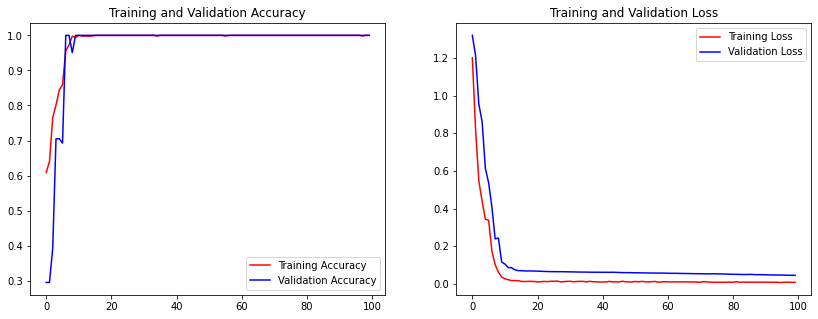

In [27]:
eval_plot(history)
evaluate(model)


In [28]:

img = image.load_img('tmp/rockpaperscissors/paper/0a3UtNzl5Ll3sq8K.png', target_size=(100,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

predict_image(img)

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

In [ ]:
img = image.load_img('tmp/rockpaperscissors/scissors/0Flw60Z2MAWWKn6S.png', target_size=(100,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

predict_image(img)

In [ ]:
img = image.load_img('tmp/rockpaperscissors/rock/0bioBZYFCXqJIulm.png', target_size=(100,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

predict_image(img)

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'